# News–Aktien-Verknüpfung mit Google Gemini

Dieses Notebook:
1. Lädt News-Daten (Finnhub) und Kursdaten (NVDA, TSLA, ASML, META, AMZN).
2. Nutzt **Google Gemini** (über deinen API-Key), um die ersten `N` News-Artikel inhaltlich zu analysieren.
3. Bestimmt für jeden Artikel:
   - ob er kursrelevant ist (Relevanz-Score),
   - welches ungefähre **Zeitfenster** (vor / nach dem Event) relevant ist,
   - eine kurze Erklärung.
4. Verknüpft das Zeitfenster mit den Kursdaten und
5. Visualisiert den Kursverlauf im relevanten Zeitraum für einen ausgewählten Artikel.

> **Hinweis:** Dieses Notebook ist so gebaut, dass es *lokal* mit Internetzugang und deinem Gemini-API-Key läuft. Hier im Chat können die externen API-Aufrufe nicht ausgeführt werden.

In [7]:

# Basis-Imports
import os
import json
from dataclasses import dataclass
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: Gemini / HTTP
try:
    import google.generativeai as genai
except ImportError:
    genai = None
    print("Warnung: 'google-generativeai' ist nicht installiert. Installiere es mit: pip install google-generativeai")


# Pandas-Optionen für schönere Ausgabe
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


In [8]:

# === Pfade zu deinen CSV-Dateien ===
# Passe diese ggf. an, wenn deine Dateien an einem anderen Ort liegen.
# === Pfade zu deinen CSV-Dateien ===

# 1️⃣ Ordner mit Kursdaten
PRICE_DATA_DIR = r"H:\Phython Prjekts\Agentic_Artificial_inteligence\Stockcorse_as_csv"

# 2️⃣ Ordner mit News-Daten
NEWS_DATA_DIR = r"H:\Phython Prjekts\Agentic_Artificial_inteligence\News data"

# === Datei-Pfade festlegen ===
NEWS_CSV = os.path.join(NEWS_DATA_DIR, "news_6m_finnhub_newsapi.csv")

PRICE_FILES = {
    "NVDA": os.path.join(PRICE_DATA_DIR, "NVDA_6monatealles.csv"),
    "TSLA": os.path.join(PRICE_DATA_DIR, "TSLA_6monatealles.csv"),
    "ASML": os.path.join(PRICE_DATA_DIR, "ASML_6monatealles.csv"),
    "META": os.path.join(PRICE_DATA_DIR, "META_6monatealles.csv"),
    "AMZN": os.path.join(PRICE_DATA_DIR, "AMZN_6monatealles.csv"),
}
# === News laden ===
news_df = pd.read_csv(NEWS_CSV)

# Versuche ein paar typische Spaltennamen zu harmonisieren
# -> passe das bei Bedarf an deine Datei-Struktur an
possible_time_cols = ["published_at_utc", "published_at", "datetime", "time"]

published_col = None
for c in possible_time_cols:
    if c in news_df.columns:
        published_col = c
        break

if published_col is None:
    raise ValueError(f"Keine Zeitspalte gefunden. Verfügbare Spalten: {list(news_df.columns)}")


# In echte Datumswerte umwandeln
news_df["published_dt"] = pd.to_datetime(news_df[published_col], utc=True, errors="coerce")

# Ticker-Spalte bestimmen
possible_ticker_cols = ["ticker", "symbol"]
ticker_col = None
for c in possible_ticker_cols:
    if c in news_df.columns:
        ticker_col = c
        break

if ticker_col is None:
    raise ValueError(f"Keine Ticker-Spalte gefunden. Verfügbare Spalten: {list(news_df.columns)}")


# Optional: nur die ersten N News verwenden
N_NEWS = 20
news_df = news_df.sort_values("published_dt").reset_index(drop=True)
news_sample = news_df.head(N_NEWS).copy()

print("Beispiel-Newszeilen:")
display(news_sample[[ticker_col, published_col]].head())


Beispiel-Newszeilen:


,ticker,published_at_utc
0,ASML,2025-10-27T18:45:04Z
1,ASML,2025-10-29T13:32:30Z
2,ASML,2025-10-29T13:36:56Z
3,ASML,2025-10-29T13:41:45Z
4,ASML,2025-10-29T13:43:00Z


In [9]:
import re

def load_price_data(price_files: dict) -> dict:
    """
    Lädt Kursdaten je Ticker in ein Dictionary {ticker: DataFrame}.

    Unterstützt zwei Formate:
    - 6monatealles.csv:  Spalten ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
      -> Datum steht in 'Price' ab der Zeile, wo 'YYYY-MM-DD' beginnt.
    - *_schlusskurse.csv: Spalten ['Price', 'Schlusskurs']
      -> Datum steht ebenfalls in 'Price' ab der Zeile mit 'YYYY-MM-DD'.
    """
    price_data = {}

    for ticker, path in price_files.items():
        if not os.path.exists(path):
            print(f"Warnung: Datei für {ticker} nicht gefunden: {path}")
            continue

        df = pd.read_csv(path)

        # 1) Versuche erstmal "normale" Datums-Spalten
        possible_date_cols = ["date", "Date", "Datum", "time", "timestamp"]
        date_col = None
        for c in possible_date_cols:
            if c in df.columns:
                date_col = c
                break

        # 2) Spezialfall: deine Dateien -> Datum steckt in 'Price'
        if date_col is None:
            if "Price" in df.columns:
                # Finde Zeilen, wo Price wie ein Datum "YYYY-MM-DD" aussieht
                mask = df["Price"].astype(str).str.match(r"\d{4}-\d{2}-\d{2}")
                if mask.any():
                    # Nur diese Zeilen behalten
                    df = df.loc[mask].copy()
                    df.rename(columns={"Price": "date"}, inplace=True)
                    date_col = "date"
                else:
                    raise ValueError(
                        f"Kein Datums-Muster in Spalte 'Price' in {path} gefunden. "
                        f"Spalten: {list(df.columns)}"
                    )
            else:
                raise ValueError(
                    f"Keine Datums-Spalte in {path} gefunden und keine 'Price'-Spalte. "
                    f"Spalten: {list(df.columns)}"
                )

        # Datums-Spalte in echtes datetime konvertieren
        df["date"] = pd.to_datetime(df[date_col], utc=True, errors="coerce")
        df = df.sort_values("date").set_index("date")

        # 3) Close-Spalte bestimmen
        possible_close_cols = ["close", "Close", "Schlusskurs", "adj_close", "Adj Close"]
        close_col = None
        for c in possible_close_cols:
            if c in df.columns:
                close_col = c
                break

        if close_col is None:
            raise ValueError(
                f"Keine Close/Schlusskurs-Spalte in {path} gefunden. "
                f"Spalten: {list(df.columns)}"
            )

        # Nur Schlusskurs behalten, auf 'close' normieren
        df = df[[close_col]].rename(columns={close_col: "close"})
        price_data[ticker] = df

    return price_data


price_data = load_price_data(PRICE_FILES)

print("Geladene Ticker:", list(price_data.keys()))
price_data["NVDA"].head()



Geladene Ticker: ['NVDA', 'TSLA', 'ASML', 'META', 'AMZN']


,close
date,
2025-06-05 00:00:00+00:00,139.97239685058594
2025-06-06 00:00:00+00:00,141.70216369628906
2025-06-09 00:00:00+00:00,142.612060546875
2025-06-10 00:00:00+00:00,143.94189453125
2025-06-11 00:00:00+00:00,142.8219451904297


In [26]:

# === Gemini-Konfiguration ===

GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY", "-")
GEMINI_MODEL_NAME = "gemini-flash-latest"  # ggf. anpassen

if GEMINI_API_KEY == "HIER_DEIN_API_KEY":
    print("Hinweis: Setze deine Gemini-API in GEMINI_API_KEY oder als Umgebungsvariable.")

if genai is not None and GEMINI_API_KEY not in (None, "HIER_DEIN_API_KEY", ""):

    genai.configure(api_key=GEMINI_API_KEY)

    try:
        gemini_model = genai.GenerativeModel(GEMINI_MODEL_NAME)
    except Exception as e:
        print("Fehler beim Initialisieren des Gemini-Modells:", e)
        gemini_model = None
else:
    gemini_model = None


In [15]:
import re
import requests

def fetch_article_text(row, url_col: str = "url") -> str:
            """Versucht den Volltext des Artikels zu holen.

            Strategien:
"
            "1. Wenn die CSV schon eine Spalte wie 'summary' oder 'headline' enthält, wird diese genutzt.
"
            "2. Wenn eine Finnhub-URL enthalten ist, wird versucht, deren API mit API-Key aufzurufen.
"
            "3. Falls eine externe URL vorhanden ist, könnte man (falls erlaubt) scraping+Gemini nutzen.
"
            """
            # 1) Direkt aus vorhandenen Spalten
            for col in ["summary", "headline", "title", "description", "text"]:
                if col in row and isinstance(row[col], str) and len(row[col].strip()) > 0:
                    # Wenn es mehrere Spalten gibt, werden sie unten ggf. in den Prompt gemischt
                    break

            texts = []
            for col in ["summary", "headline", "title", "description", "text"]:
                if col in row and isinstance(row[col], str):
                    texts.append(f"{col}: {row[col]}")

            base_text = "\n".join(texts)
            if base_text:
                return base_text

            # 2) Finnhub-URL (Beispiel: https://finnhub.io/api/news?id=... )
            if url_col in row and isinstance(row[url_col], str):
                url = row[url_col]
            else:
                return ""

            if "finnhub.io" in url and GEMINI_API_KEY not in (None, "HIER_DEIN_API_KEY", ""):  # hier wird angenommen, dass Finnhub und Gemini denselben Key nutzen, ggf. anpassen
                try:
                    # HINWEIS: Passen je nach Struktur deiner Finnhub-URL an
                    if "token=" not in url:
                        sep = "&" if "?" in url else "?"
                        api_url = f"{url}{sep}token={GEMINI_API_KEY}"
                    else:
                        api_url = url

                    resp = requests.get(api_url, timeout=10)
                    if resp.ok:
                        data = resp.json()
                        # Versuch typische Felder
                        for key in ["summary", "text", "headline"]:
                            if key in data and isinstance(data[key], str):
                                return data[key]
                except Exception as e:
                    print("Fehler beim Holen der Finnhub-News:", e)

            # 3) Fallback: Nur URL zurückgeben, später direkt im Gemini-Prompt verwenden
            return base_text or f"URL: {row.get(url_col, '')}"



In [16]:

# === Heuristische Analyse (Fallback, wenn Gemini nicht verfügbar ist) ===

TIMEFRAME_SHORT = "short_term"
TIMEFRAME_MEDIUM = "medium_term"
TIMEFRAME_LONG = "long_term"

@dataclass
class TimeframeResult:
    timeframe: str
    window_start: datetime
    window_end: datetime
    relevance_score: float
    comment: str


def classify_timeframe_heuristic(text: str, published_dt: datetime) -> TimeframeResult:
    """Einfache regelbasierte Heuristik, falls Gemini nicht genutzt werden kann.

    - Sucht nach Begriffen wie 'next week', 'in 3 days', '2026' etc.

    - Legt ein relevantes Fenster um published_dt fest.

    """
    if not isinstance(published_dt, datetime):
        raise ValueError("published_dt muss ein datetime sein")


    t = (text or "").lower()

    # Standard-Fenster: 1 Tag vor bis 2 Tage nach Veröffentlichung
    default_start = published_dt - timedelta(days=1)
    default_end = published_dt + timedelta(days=2)
    timeframe = TIMEFRAME_MEDIUM

    # Long-Term Indikatoren
    if re.search(r"2026|2027|2028|long term|long-term|years to come|next years|multi-year", t):
        timeframe = TIMEFRAME_LONG
        window_start = published_dt
        window_end = published_dt + timedelta(days=365)
        comment = "Text erwähnt deutlich langfristige Perspektiven (>= 1 Jahr)."
        return TimeframeResult(timeframe, window_start, window_end, 0.7, comment)

    # Medium-Term (nächste Monate)
    if re.search(r"next quarter|coming months|next few quarters|over the next year", t):
        timeframe = TIMEFRAME_MEDIUM
        window_start = published_dt
        window_end = published_dt + timedelta(days=120)
        comment = "Text spricht über die nächsten Monate / Quartale."
        return TimeframeResult(timeframe, window_start, window_end, 0.6, comment)

    # Short-Term (z.B. Earnings, Analyst-Upgrade, 'today', 'this week')
    if re.search(r"earnings|guidance|forecast|beat estimates|missed estimates|upgrade|downgrade|this week|today|immediate", t):
        timeframe = TIMEFRAME_SHORT
        window_start = published_dt - timedelta(days=1)
        window_end = published_dt + timedelta(days=3)
        comment = "News wirkt typischerweise kurzfristig (Earnings/Upgrade etc.)."
        return TimeframeResult(timeframe, window_start, window_end, 0.8, comment)

    # Spezielle relative Angaben: '5 hours ago' etc.
    m_hours = re.search(r"(\d+)\s+hours? ago", t)
    if m_hours:
        hours = int(m_hours.group(1))
        # grob: runde auf Vortag bis +1 Tag
        window_start = (published_dt - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
        window_end = (published_dt + timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)
        timeframe = TIMEFRAME_SHORT
        comment = f"Artikel erwähnt ein Ereignis vor {hours} Stunden; Fenster ~gestern bis morgen."
        return TimeframeResult(timeframe, window_start, window_end, 0.75, comment)

    # 'next week'
    if "next week" in t:
        # im Sinne deines Beispiels:
        # - ab Veröffentlichungstag bis Ende des Tages
        # - 1 Tag vor 'next week' und 2 Tage danach
        pub_day_start = published_dt.replace(hour=0, minute=0, second=0, microsecond=0)
        window_start = pub_day_start
        # 'next week' ~ +7 Tage ab Veröffentlichung
        next_week_start = pub_day_start + timedelta(days=7)
        window_end = next_week_start + timedelta(days=2)
        timeframe = TIMEFRAME_MEDIUM
        comment = "Artikel erwähnt 'next week'; Relevanz von heute bis kurz nach nächster Woche."
        return TimeframeResult(timeframe, window_start, window_end, 0.7, comment)

    # Fallback: mittel-lang
    window_start = default_start
    window_end = default_end
    comment = "Keine expliziten Zeitangaben gefunden; Standardfenster um Veröffentlichung."
    return TimeframeResult(timeframe, window_start, window_end, 0.5, comment)


In [30]:
# === Gemini-basierte Analyse ===

def analyze_with_gemini(text: str, published_dt: datetime):
    """Fragt Gemini nach einer strukturierten Einschätzung.
    Erwartete Rückgabe (aus dem Modell):
    {
      "relevance_score": float (0-1),
      "timeframe": "short_term" | "medium_term" | "long_term",
      "window_start_offset_days": float,
      "window_end_offset_days": float,
      "comment": str
    }
    Wenn Gemini nicht verfügbar ist oder ein Fehler auftritt, wird None zurückgegeben.
    """
    if gemini_model is None or genai is None or not text:
        return None

    if not isinstance(published_dt, datetime):
        raise ValueError("published_dt muss ein datetime sein")

    prompt = f"""
Du bist ein Analyst für Finanznachrichten.
Du bekommst:
1. Den Volltext oder eine Zusammenfassung eines News-Artikels zu einer Aktie.
2. Den Veröffentlichungszeitpunkt (UTC).

Aufgabe:
- Bestimme, ob die News voraussichtlich eher kurzfristig, mittelfristig oder langfristig kursrelevant ist.
- Schätze ein sinnvolles Zeitfenster (Start/Ende relativ zum Veröffentlichungszeitpunkt in Tagen).
- Gib einen Relevanz-Score (0-1), wie stark du die News als marktbewegend einschätzt.
- Erkläre kurz, warum.

WICHTIG: Antworte **ausschließlich** mit einem JSON-Objekt mit folgenden Feldern:

{{
  "relevance_score": <float zwischen 0 und 1>,
  "timeframe": "short_term" oder "medium_term" oder "long_term",
  "window_start_offset_days": <float, z.B. -1.0 für 1 Tag vor Veröffentlichung>,
  "window_end_offset_days": <float, z.B. 3.0 für 3 Tage nach Veröffentlichung>,
  "comment": "kurze Erklärung auf Englisch oder Deutsch"
}}

Text des Artikels:
\"\"\"{text}\"\"\"

Veröffentlichungszeitpunkt (UTC): {published_dt.isoformat()}
"""

    try:
        response = gemini_model.generate_content(prompt)

        # Roh-Text holen und säubern
        raw = (response.text or "").strip()
        if not raw:
            # nichts zurückbekommen -> Modell schweigt / Safety -> Fallback
            return None

        # Falls Gemini trotzdem ```json ... ``` drum herum packt:
        if raw.startswith("```"):
            # ```json\n{ ... }\n```  ->  nur den JSON-Teil übrig lassen
            lines = raw.strip("`").splitlines()
            if lines and lines[0].strip().lower().startswith("json"):
                lines = lines[1:]  # "json" Zeile entfernen
            raw = "\n".join(lines).strip()

        # Nur den Teil zwischen erstem '{' und letztem '}' extrahieren
        start = raw.find("{")
        end = raw.rfind("}")
        if start == -1 or end == -1:
            # Kein JSON gefunden -> Fallback
            # print("Gemini-Antwort enthält kein erkennbares JSON, fallback auf Heuristik.")
            return None

        json_str = raw[start:end + 1]

        data = json.loads(json_str)
        return data

    except Exception as e:
        # Hier nicht ausrasten, nur ruhig sagen, dass wir auf Heuristik gehen
        print("Fehler bei Gemini-Analyse (fallback auf Heuristik):", e)
        return None

def combine_gemini_and_heuristic(text: str, published_dt: datetime) -> TimeframeResult:
    """Versucht zuerst Gemini. Fällt bei Fehler auf Heuristik zurück."""
    gem_res = analyze_with_gemini(text, published_dt)
    if gem_res is not None:
        try:
            timeframe = gem_res.get("timeframe", TIMEFRAME_MEDIUM)
            rs = float(gem_res.get("relevance_score", 0.5))
            offset_start = float(gem_res.get("window_start_offset_days", -1.0))
            offset_end = float(gem_res.get("window_end_offset_days", 2.0))
            comment = str(gem_res.get("comment", ""))

            window_start = published_dt + timedelta(days=offset_start)
            window_end = published_dt + timedelta(days=offset_end)

            return TimeframeResult(timeframe, window_start, window_end, rs, comment)
        except Exception as e:
            print("Fehler beim Verarbeiten der Gemini-Antwort, fallback auf Heuristik:", e)

    # Fallback: reine Heuristik
    return classify_timeframe_heuristic(text, published_dt)


In [31]:

# === News anreichern (erste N_NEWS Einträge) ===

# Bestimme die Spaltennamen noch einmal explizit
news_ticker_col = ticker_col
news_time_col = published_col
news_url_col = "url" if "url" in news_df.columns else None

enriched_rows = []

for idx, row in news_sample.iterrows():
    pub_dt = row["published_dt"]
    ticker = row[news_ticker_col]
    article_id = idx  # einfacher Index als ID

    article_text = fetch_article_text(row, url_col=news_url_col or "url")

    tf_result = combine_gemini_and_heuristic(article_text, pub_dt)

    enriched_rows.append({
        "article_id": article_id,
        "ticker": ticker,
        "published_dt": pub_dt,
        "raw_text": article_text,
        "timeframe": tf_result.timeframe,
        "window_start": tf_result.window_start,
        "window_end": tf_result.window_end,
        "relevance_score": tf_result.relevance_score,
        "comment": tf_result.comment,
        **{col: row[col] for col in news_sample.columns if col not in ["published_dt"]},
    })

enriched_df = pd.DataFrame(enriched_rows)
enriched_df = enriched_df.sort_values("published_dt").reset_index(drop=True)

print("Enriched News:")
display(enriched_df[["article_id", "ticker", "published_dt", "timeframe", "relevance_score", "comment"]].head())

# Optional: Speichern
ENRICHED_PATH = os.path.join(NEWS_DATA_DIR, "news_enriched_with_timeframes.csv")
enriched_df.to_csv(ENRICHED_PATH, index=False)
print("Gespeichert unter:", ENRICHED_PATH)
import google.generativeai as genai

genai.configure(api_key=GEMINI_API_KEY)

for m in genai.list_models():
    if "generateContent" in getattr(m, "supported_generation_methods", []):
        print(m.name)



Fehler bei Gemini-Analyse (fallback auf Heuristik): 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 41.058694148s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  seconds: 41
}
]
Fehler bei Gemini-Analyse (fallback auf Heur

,article_id,ticker,published_dt,timeframe,relevance_score,comment
0,0,ASML,2025-10-27 18:45:04+00:00,medium_term,0.55,The article is an investment recommendation fo...
1,1,ASML,2025-10-29 13:32:30+00:00,short_term,0.90,Reaching a $5 trillion valuation is a massive ...
2,2,ASML,2025-10-29 13:36:56+00:00,short_term,0.85,The $5T valuation milestone is highly symbolic...
3,3,ASML,2025-10-29 13:41:45+00:00,medium_term,0.90,Reaching the $5T market capitalization milesto...
4,4,ASML,2025-10-29 13:43:00+00:00,short_term,0.95,Achieving the $5 trillion valuation is a histo...


Gespeichert unter: H:\Phython Prjekts\Agentic_Artificial_inteligence\News data\news_enriched_with_timeframes.csv
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/n

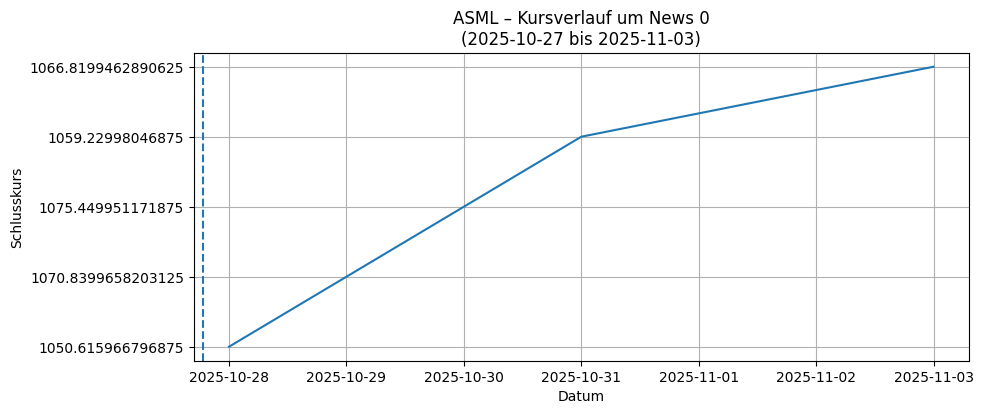

Ticker: ASML
Veröffentlichung: 2025-10-27 18:45:04+00:00
Timeframe: medium_term
Relevanz-Score: 0.55
Kommentar: The article is an investment recommendation focused on a decade-long growth thesis. While the fundamental analysis is long-term, the market relevance is immediate and medium-term, driven by retail investor interest and resulting short-term buying pressure following the publication of the recommendation.


In [34]:

# === Visualisierung: Kursverlauf im relevanten Zeitfenster ===

def get_price_window(ticker: str, start: datetime, end: datetime) -> pd.DataFrame:
    if ticker not in price_data:
        raise ValueError(f"Keine Kursdaten für {ticker} geladen.")
    df = price_data[ticker]
    # df hat DatetimeIndex (UTC)
    mask = (df.index >= start) & (df.index <= end)
    return df.loc[mask].copy()


def plot_article_window(article_id: int):
    """Zeigt Kursverlauf für die Aktie im relevanten Zeitfenster der News."""
    row = enriched_df.loc[enriched_df["article_id"] == article_id]
    if row.empty:
        raise ValueError(f"article_id {article_id} nicht gefunden.")
    row = row.iloc[0]

    ticker = row["ticker"]
    start = row["window_start"]
    end = row["window_end"]
    pub = row["published_dt"]

    price_window = get_price_window(ticker, start, end)

    if price_window.empty:
        print("Keine Kursdaten im angegebenen Fenster gefunden.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(price_window.index, price_window["close"])
    # Veröffentlichung markieren
    plt.axvline(pub, linestyle="--")  # keine Farbe explizit setzen
    plt.title(f"{ticker} – Kursverlauf um News {article_id}\n({start.date()} bis {end.date()})")
    plt.xlabel("Datum")
    plt.ylabel("Schlusskurs")
    plt.grid(True)
    plt.show()

    print("Ticker:", ticker)
    print("Veröffentlichung:", pub)
    print("Timeframe:", row["timeframe"])
    print("Relevanz-Score:", row["relevance_score"])
    print("Kommentar:", row["comment"])
plot_article_window(article_id=0)

# Beispielaufruf (passe die ID an, die dich interessiert):
# plot_article_window(article_id=0)


In [33]:

# === Optional: Interaktive Auswahl mit ipywidgets ===
try:
    import ipywidgets as widgets
    from IPython.display import display

    def interactive_plot():
        options = [(f"{int(row['article_id'])} | {row.get('ticker')} | {row.get('published_dt')} | {str(row.get('timeframe'))}", int(row['article_id']))
                   for _, row in enriched_df.iterrows()]

        dropdown = widgets.Dropdown(options=options, description="Artikel:")

        def on_change(change):
            if change['name'] == 'value' and change['new'] is not None:
                plot_article_window(change['new'])

        dropdown.observe(on_change, names='value')
        display(dropdown)

    print("Nutze 'interactive_plot()' für eine interaktive Auswahl im Notebook.")
except ImportError:
    print("ipywidgets nicht installiert. Installiere mit: pip install ipywidgets")


ipywidgets nicht installiert. Installiere mit: pip install ipywidgets
